# Modelo 3 - DBSCAN

### Carga de datos procesados

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [2]:
# Lectura de datos
df_habitantes = pd.read_csv('../datos/procesados/habitantes_de_calle_2022_procesado.csv')

In [3]:
# Toma de columnas relacionadas con drogas que consume actualmente y edad de inicio de consumo
# col_consumo_actual = [col for col in df_habitantes.columns if col.lower().startswith('actualmente')]
col_edad_inicio_consumo = [col for col in df_habitantes.columns if col.lower().startswith('edad inicio')]
df_consumo_drogas = df_habitantes[col_edad_inicio_consumo + ['hombre o mujer']].copy()
df_consumo_drogas.head()


,Edad inicio del consumo 1 cigarrillo,"Edad inicio del consumo 2 alcohol (Bebidas alcohólicas, chamber, etílico)",Edad inicio del consumo 3 marihuana,"Edad inicio del consumo 4 inhalantes (sacol, pegante, boxer, gasolina, thiner, etc)",Edad inicio del consumo 5 cocaína,Edad inicio del consumo 6 basuco,Edad inicio del consumo 7 heroína,Edad inicio del consumo 8 pepas,"Edad inicio del consumo 9 otras (maduro, pistolo, etc)",hombre o mujer
0,15.0,16.0,15.0,15.0,16.0,17.0,18.0,16.0,16.0,1.0
1,15.0,16.0,15.0,15.0,16.0,17.0,18.0,16.0,16.0,1.0
2,15.0,16.0,15.0,15.0,16.0,17.0,18.0,16.0,16.0,1.0
3,15.0,16.0,15.0,15.0,16.0,17.0,18.0,16.0,16.0,1.0
4,15.0,16.0,15.0,15.0,16.0,17.0,18.0,16.0,16.0,1.0


In [4]:
# Captura del nombre
def extraer_sustancia(col):
    ''' Extrae solo la sustancia del nombre de la columna y la renombra solo con la sustancia'''
    match = re.search(r'consumo\s+\d+\s+([^\(]+)', col.lower())
    if match:
        sustancia = match.group(1).strip()
        return sustancia.capitalize()
    return col

In [5]:
# Cambio de nombre de columnas
df_consumo_drogas.columns = [extraer_sustancia(col) if 'consumo' in col.lower() else col for col in df_consumo_drogas.columns]

In [6]:
df_consumo_drogas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5343 entries, 0 to 5342
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cigarrillo      5343 non-null   float64
 1   Alcohol         5343 non-null   float64
 2   Marihuana       5343 non-null   float64
 3   Inhalantes      5343 non-null   float64
 4   Cocaína         5343 non-null   float64
 5   Basuco          5343 non-null   float64
 6   Heroína         5343 non-null   float64
 7   Pepas           5343 non-null   float64
 8   Otras           5343 non-null   float64
 9   hombre o mujer  5343 non-null   float64
dtypes: float64(10)
memory usage: 417.6 KB


In [7]:
scaler = StandardScaler()
df_consumo_drogas_escalado = scaler.fit_transform(df_consumo_drogas)

### Modelo DBSCAN sin PCA

#### Hiperparámetros

In [9]:
from sklearn.neighbors import NearestNeighbors
from itertools import product # Convierte los arange en una matriz

In [17]:
neighbors = NearestNeighbors(n_neighbors=2) # Encontrar a los vecinos más cercanos - Medir distancias, para el parámetro se puede tomar la cantidad de features multiplicado por 2 y tomar ese número o uno cercano

neighbors_fit = neighbors.fit(df_consumo_drogas_escalado) # Entreno
distances, index = neighbors_fit.kneighbors(df_consumo_drogas_escalado) # Mido las distancias

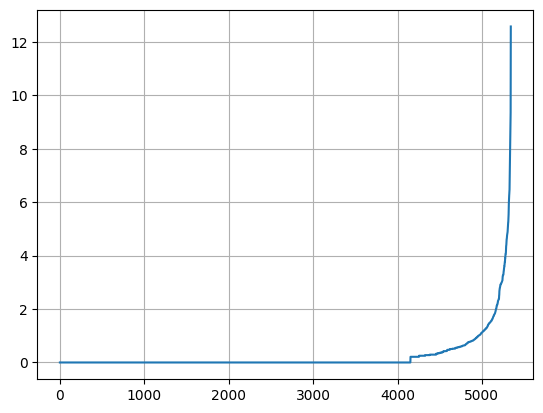

In [18]:
# Esto nos ayuda a ver la gráfica de rodilla y sacar los valores que se ubiquen en la curva
distances = np.sort(distances, axis=0)
distances = distances[:, -1]
plt.plot(distances)
plt.grid()

Búsqueda de epsilon y min_samples

In [19]:
# Se crean dos listas
eps_values = np.arange(0.25, 0.80, 0.10)
min_samples = np.arange(2, 10)

In [20]:
db_scan_params = list(product(eps_values, min_samples)) # Crea una lista con los eps y los min para luego iterar
sil_scores = [] # Lista vacía para guardar el coeficiente de silueta

for param in db_scan_params:
    y_pred = DBSCAN(eps=param[0], min_samples=param[1]).fit_predict(df_consumo_drogas_escalado)
    etiquetas_y_pred = set(y_pred)

    if len(etiquetas_y_pred - {-1}) >= 2:
        score = silhouette_score(df_consumo_drogas_escalado, y_pred)
    else:
        score = -1
    sil_scores.append(score)

In [23]:
df_params_tuning = pd.DataFrame.from_records(db_scan_params, columns=['Eps', 'Min_Samples']) # Crea un df de la lista db_scan_params
df_params_tuning['Sil_Scores'] = sil_scores # Se agrega la lista que se alimentó con el for

In [24]:
# Creamos una matriz
pivot_data = pd.pivot_table(df_params_tuning, values='Sil_Scores', index='Min_Samples', columns='Eps')

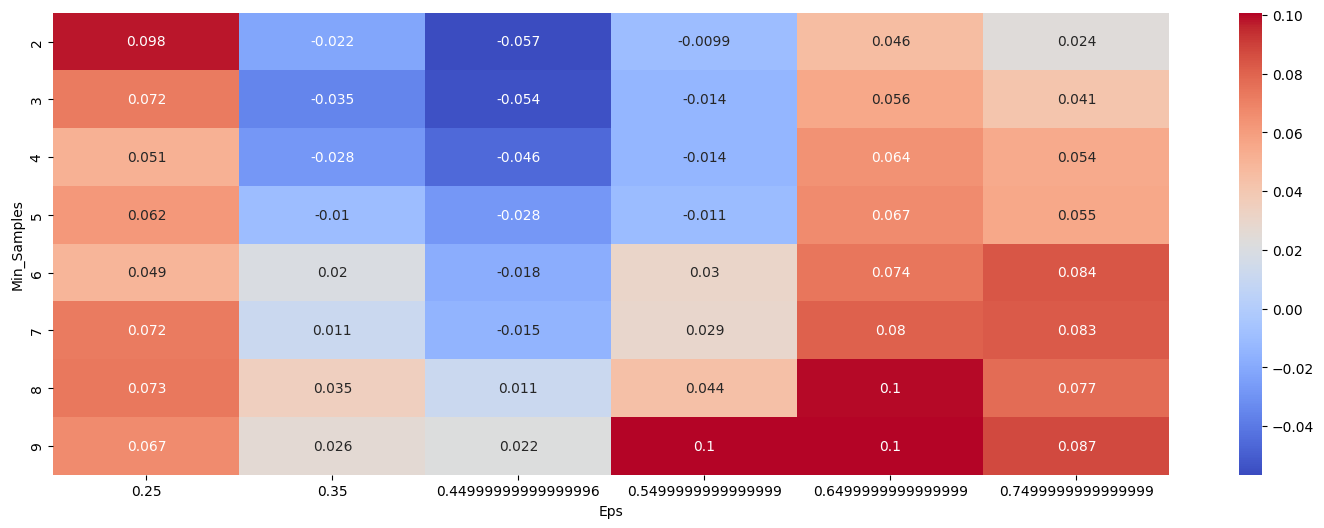

In [25]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot_data, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show();

#### Aplicación del modelo

In [27]:
dbscan_cluster = DBSCAN(eps=0.65, min_samples=8) # Se tunea con los hiperparámetros encontrados anteriormente
y_predict_cluster = dbscan_cluster.fit_predict(df_consumo_drogas_escalado)
df_consumo_drogas['cluster'] = y_predict_cluster

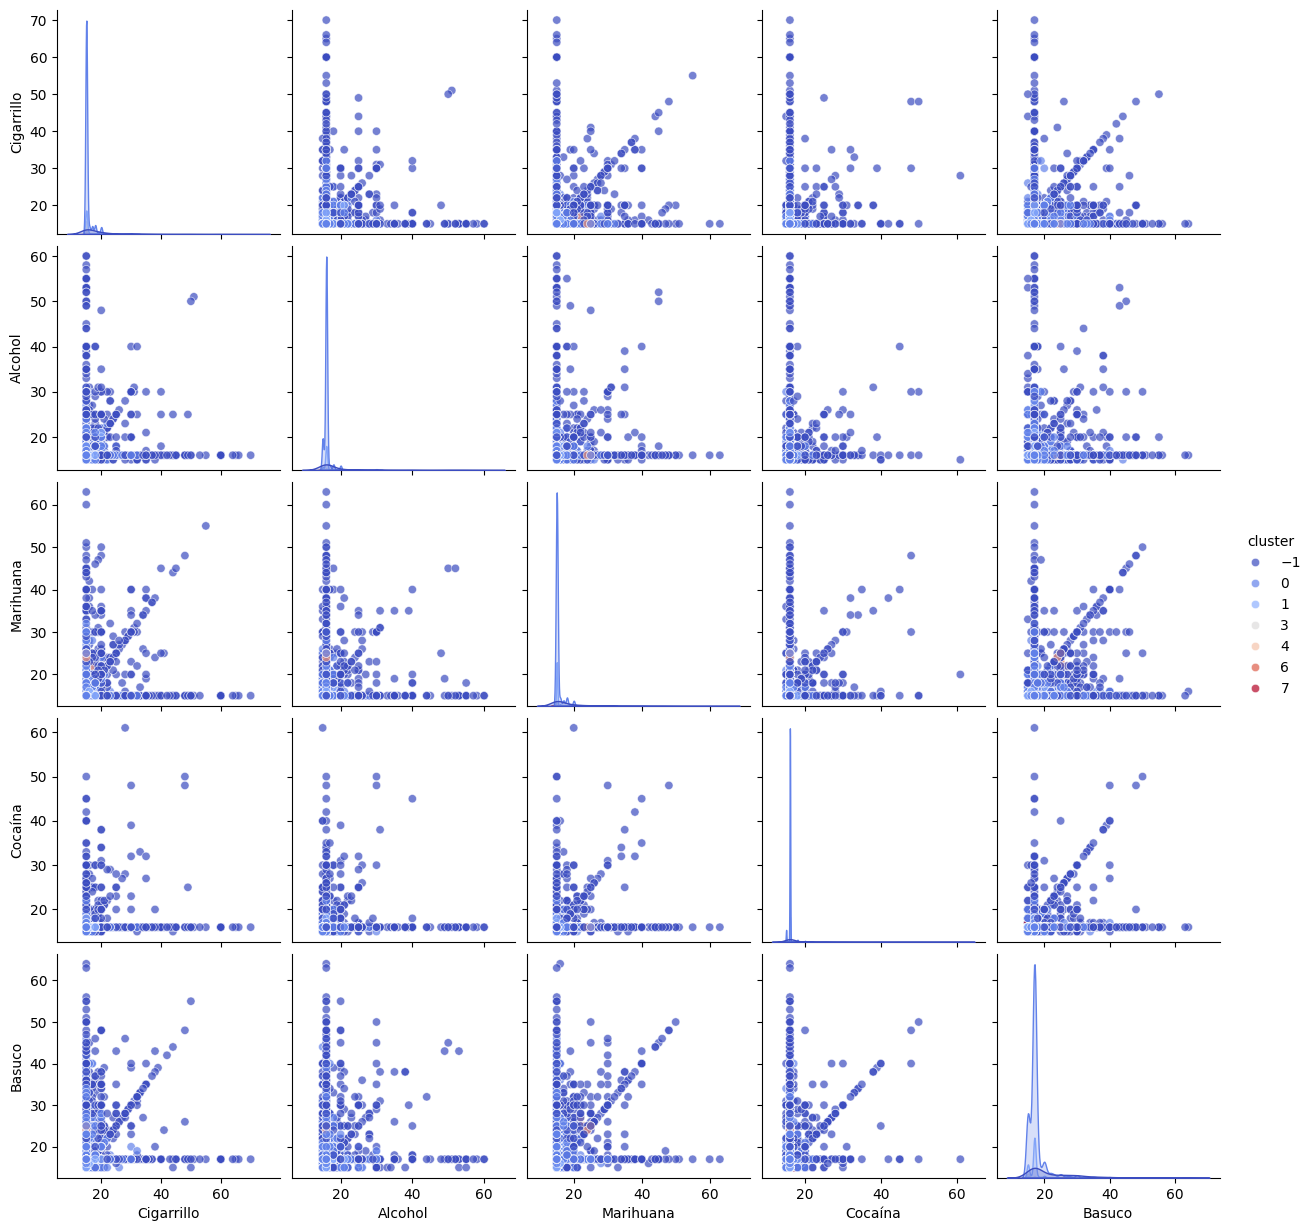

In [28]:
# gráfica del modelo con algunas variables
sns.pairplot(df_consumo_drogas[['Cigarrillo', 'Alcohol', 'Marihuana', 'Cocaína', 'Basuco', 'cluster']], hue='cluster', palette='coolwarm', plot_kws={'alpha':0.7 })
plt.show();

### Evaluación del modelo sin PCA

In [32]:
# Filtrar puntos que no son ruido
mask_no_ruido = y_predict_cluster != -1
x_no_ruido = df_consumo_drogas_escalado[mask_no_ruido]
labels_no_ruido = y_predict_cluster[mask_no_ruido]

# Métrica 1: Silhouette Score (solo puntos no ruido)
if len(set(labels_no_ruido)) > 1:
    sil_score = silhouette_score(x_no_ruido, labels_no_ruido)
else:
    sil_score = None  # No se puede calcular si hay solo un clúster

# Métrica 2: Porcentaje de ruido
n_ruido = np.sum(y_predict_cluster == -1)
porcentaje_ruido = n_ruido / len(y_predict_cluster)

# Métrica 3: Número de clústeres detectados (excluyendo ruido)
n_clusters = len(set(y_predict_cluster)) - (1 if -1 in y_predict_cluster else 0)

# Mostrar resultados
print(f"Número de clústeres detectados: {n_clusters}")
print(f"Porcentaje de puntos como ruido: {porcentaje_ruido:.2%}")
if sil_score is not None:
    print(f"Silhouette Score (sin ruido): {sil_score:.4f}")
else:
    print("No se puede calcular Silhouette Score (solo hay un clúster sin ruido)")


Número de clústeres detectados: 8
Porcentaje de puntos como ruido: 16.25%
Silhouette Score (sin ruido): 0.1995
